<a href="https://colab.research.google.com/github/ds-kenwatanabe/google_colab_projects/blob/main/Food101_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learing from pre-trained PyTorch models and comparing models tested.

This Google Colaboratory uses the Food101 DataSet, for more info: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

see also the PyTorch documentation: https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101

The aim is to find the best performing and lowest size model.
    
* Use the best performing model to edge device (i.e., not cloud).

**Note**

Edge device differente from IoT: https://aws.amazon.com/pt/blogs/machine-learning/demystifying-machine-learning-at-the-edge-through-real-use-cases/

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchvision.datasets import Food101
try:
    from torchinfo import summary
except:
    print("[INFO] torchinfo not found. Installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
# Run device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Download Food101 data and create DataLoaders

In [ ]:
from torchvision.transforms.transforms import ToTensor
# Train and test DataLoaders
train_data = Food101(root="data",
                     download=True,
                     split="train",
                     transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.ToTensor()]))

test_data = Food101(root="data",
                    download=True,
                    split="test",
                    transform=transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor()]))

In [ ]:
# See classes
class_names = train_data.classes
class_names, len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  'hummu

## Creating functions

The functions next will be used to help test, train, and evaluate the model(s)

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()


def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

## Transfer Learning model 1 - using MNASNet1_3

See documentation: https://pytorch.org/vision/stable/models/generated/torchvision.models.mnasnet1_3.html#torchvision.models.MNASNet1_3_Weights

See paper: https://arxiv.org/abs/1807.11626

In [ ]:
from torchvision.models.mnasnet import mnasnet1_3
# Set up pretrained MNASNet1_3 weights
mnasnet1_3_weights = torchvision.models.MNASNet1_3_Weights.DEFAULT

# Get transforms
mnasnet1_3_transforms = mnasnet1_3_weights.transforms

# Set up pretrained model instance
mnasnet1_3 = torchvision.models.mnasnet1_3(weights=mnasnet1_3_weights)

# Freeze the base layers in the model (stop layers from training)
for param in mnasnet1_3.parameters():
    param.requires_grad = False

In [ ]:
summary(mnasnet1_3,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MNASNet (MNASNet)                             [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (layers)                         [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 40, 112, 112]    (1,080)              False
│    └─BatchNorm2d (1)                        [1, 40, 112, 112]    [1, 40, 112, 112]    (80)                 False
│    └─ReLU (2)                               [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Conv2d (3)                             [1, 40, 112, 112]    [1, 40, 112, 112]    (360)                False
│    └─BatchNorm2d (4)                        [1, 40, 112, 112]    [1, 40, 112, 112]    (80)                 False
│    └─ReLU (5)                               [1, 40, 112, 112]    [1, 40, 112,

In [ ]:
# See the classifier
mnasnet1_3.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# Change the classifier to the number of classes needed (101 classes)
mnasnet1_3.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=101, bias=True)
)

In [ ]:
# See summary after classifier change
summary(mnasnet1_3,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MNASNet (MNASNet)                             [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (layers)                         [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 40, 112, 112]    (1,080)              False
│    └─BatchNorm2d (1)                        [1, 40, 112, 112]    [1, 40, 112, 112]    (80)                 False
│    └─ReLU (2)                               [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Conv2d (3)                             [1, 40, 112, 112]    [1, 40, 112, 112]    (360)                False
│    └─BatchNorm2d (4)                        [1, 40, 112, 112]    [1, 40, 112, 112]    (80)                 False
│    └─ReLU (5)                               [1, 40, 112, 112]    [1, 40, 11

## Creating MNASNet1_3 DataLoaders

In [ ]:
BATCH_SIZE = 64

train_dataloader_mnasnet1_3 = DataLoader(train_data,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

test_dataloader_mnasnet1_3 = DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

In [ ]:
len(train_dataloader_mnasnet1_3), len(test_dataloader_mnasnet1_3), len(class_names)

(1184, 395, 101)

In [ ]:
# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mnasnet1_3.parameters(), lr=1e-3)

# Training function
mnasnet1_3_results = train(model=mnasnet1_3,
                           train_dataloader=train_dataloader_mnasnet1_3,
                           test_dataloader=test_dataloader_mnasnet1_3,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=5,
                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6833 | train_acc: 0.4048 | test_loss: 2.2891 | test_acc: 0.4210
Epoch: 2 | train_loss: 1.9616 | train_acc: 0.5207 | test_loss: 1.9121 | test_acc: 0.5059
Epoch: 3 | train_loss: 1.8202 | train_acc: 0.5439 | test_loss: 1.7775 | test_acc: 0.5420
Epoch: 4 | train_loss: 1.7443 | train_acc: 0.5591 | test_loss: 1.6979 | test_acc: 0.5607
Epoch: 5 | train_loss: 1.6974 | train_acc: 0.5680 | test_loss: 1.6774 | test_acc: 0.5645


## Plot the loss curves

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    return plt.show()

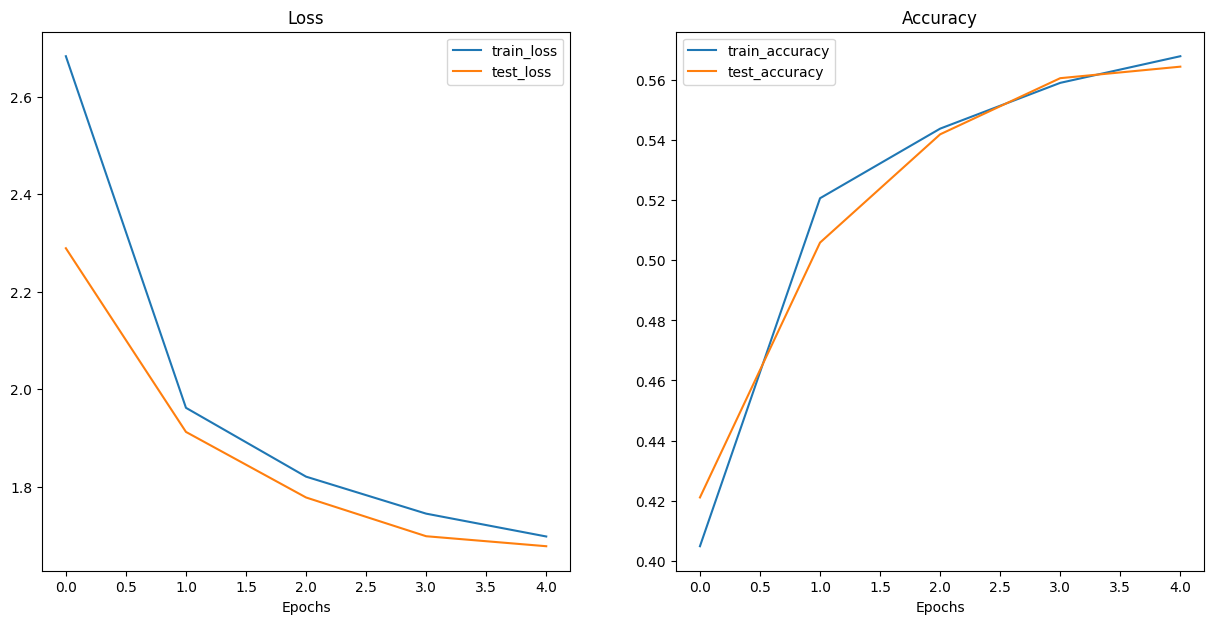

In [ ]:
plot_loss_curves(mnasnet1_3_results)

In [ ]:
# Save model function
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    import torch
    from pathlib import Path
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(model=mnasnet1_3,
           target_dir="models",
           model_name="mnasnet1_3_food101.pth")

[INFO] Saving model to: models/mnasnet1_3_food101.pth


## Transfer Learning using RegNet_Y_1_6GF

See the documentation: https://pytorch.org/vision/stable/models/generated/torchvision.models.regnet_y_1_6gf.html#torchvision.models.RegNet_Y_1_6GF_Weights
See the paper: https://arxiv.org/abs/2003.13678

In [ ]:
from torchvision.models.regnet import regnet_y_1_6gf
# Set up pretrained MNASNet1_3 weights
regnet_y_1_6gf_weights = torchvision.models.RegNet_Y_1_6GF_Weights

# Get transforms
regnet_y_1_6gf_transforms = regnet_y_1_6gf_weights.transforms

# Set up pretrained model instance
regnet_y_1_6gf = torchvision.models.regnet_y_1_6gf(weights=regnet_y_1_6gf_weights)

# Freeze the base layers in the model (stop layers from training)
for param in regnet_y_1_6gf.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_1_6GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_1_6GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_1_6gf-b11a554e.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_1_6gf-b11a554e.pth
100%|██████████| 43.2M/43.2M [00:00<00:00, 115MB/s]


In [ ]:
summary(regnet_y_1_6gf,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [1, 3, 224, 224]     [1, 1000]            --                   False
├─SimpleStemIN (stem)                                        [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    └─Conv2d (0)                                            [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    └─BatchNorm2d (1)                                       [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    └─ReLU (2)                                              [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
├─Sequential (trunk_output)                                  [1, 32, 112, 112]    [1, 888, 7, 7]       --                   False
│    └─AnyStage (block1)                                     [1, 32, 112, 112]    [1, 48,

In [ ]:
# See the linear layer
regnet_y_1_6gf.fc

Linear(in_features=888, out_features=1000, bias=True)

In [ ]:
# Change linear layer
regnet_y_1_6gf.fc = nn.Linear(in_features=888, out_features=len(class_names), bias=True)

In [ ]:
# See model after classifier change
summary(regnet_y_1_6gf,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [1, 3, 224, 224]     [1, 101]             --                   Partial
├─SimpleStemIN (stem)                                        [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    └─Conv2d (0)                                            [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    └─BatchNorm2d (1)                                       [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    └─ReLU (2)                                              [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
├─Sequential (trunk_output)                                  [1, 32, 112, 112]    [1, 888, 7, 7]       --                   False
│    └─AnyStage (block1)                                     [1, 32, 112, 112]    [1, 4

## Creating RegNet_Y_1_6GF DataLoaders

In [ ]:
BATCH_SIZE = 64

train_dataloader_regnet_y_1_6gf = DataLoader(train_data,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

test_dataloader_regnet_y_1_6gf = DataLoader(test_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)

In [ ]:
len(train_dataloader_regnet_y_1_6gf), len(test_dataloader_regnet_y_1_6gf), len(class_names)

(1184, 395, 101)

In [ ]:
# Using same optimizer and loss function as befeore (MNASNet model)
# Training model and saving results to dictionary
regnet_y_1_6gf_results = train(model=regnet_y_1_6gf,
                               train_dataloader=train_dataloader_regnet_y_1_6gf,
                               test_dataloader=test_dataloader_regnet_y_1_6gf,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6771 | train_acc: 0.0107 | test_loss: 4.6757 | test_acc: 0.0099
Epoch: 2 | train_loss: 4.6771 | train_acc: 0.0107 | test_loss: 4.6764 | test_acc: 0.0100


KeyboardInterrupt: ignored

In [ ]:
# Plot loss curves
plot_loss_curves(regnet_y_1_6gf_results)

In [ ]:
# Save RegNet model
save_model(regnet_y_1_6gf,
           target_dir="models",
           model_name="regnet_y_6gf_food101.pth")

## Checking the sizes of the models and comparing results

In [ ]:
from pathlib import Path

# get the model size in bytes then convert to megabytes
mnasnet1_3_model_size = Path("models/regnet_y_1_6gf.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained MNASNet1_3 model size: {mnasnet1_3_model_size:.2f} MB")

regnet_y_1_6gf_model_size = Path("models/regnet_y_1_6gf.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained RegNet_Y_1_6GF model size: {regnet_y_1_6gf_model_size:.2f} MB")

In [ ]:
# Comparing total parameters
mnasnet_total_params = sum(torch.numel(param) for param in mnasnet1_3.parameters())
regnet_total_params = sum(torch.numel(param) for param in regnet_y_1_6gf.parameters())

print(f"MNASNET1_3 total parameters: {mnasnet_total_params}. RegNet_Y_1_6GF total parameters: {regnet_total_params}")

In [ ]:
# See total stats
mnasnet_stats = {"test_loss": mnasnet1_3_results["test_loss"][-1],
                "test_acc": mnasnet1_3_results["test_acc"][-1],
                "number_of_parameters": mnasnet_total_params,
                "model_size (MB)": mnasnet1_3_model_size}

regnet_stats = {"test_loss": regnet_y_1_6gf_results["test_loss"][-1],
                "test_acc": regnet_y_1_6gf_results["test_acc"][-1],
                "number_of_parameters": regnet_total_params,
                "model_size (MB)": regnet_y_1_6gf_model_size}

mnasnet_stats, regnet_stats